In [24]:
!pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
!python -m pip install -U pip
!pip -V
!pip install sklearn pandas

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
pip 20.2.4 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [26]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.3
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [27]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [28]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [30]:
# RandomizedSearchCV
# 1.转化为sklearn的model
# 2.定义参数集合
# 3.搜索参数

def build_model(hidden_layers = 1,layer_size = 30, learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation = 'relu'))
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(learning_rate)
    
    model.compile(loss='mse', optimizer=optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)
]
history = sklearn_model.fit(x_train_scaled, y_train,
                   validation_data=(x_valid_scaled, y_valid),
                   epochs=20,
                   callbacks=callbacks)

Epoch 1/20
363/363 [==============================] - 0s 1ms/step - loss: 1.1407 - val_loss: 0.7505
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6540 - val_loss: 0.6640
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5917 - val_loss: 0.6106
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5483 - val_loss: 0.5951
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5153 - val_loss: 0.5389
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4981 - val_loss: 0.5219
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4809 - val_loss: 0.5201
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4682 - val_loss: 0.4922
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4576 - val_loss: 0.4782
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4488 - val_loss: 0.4726

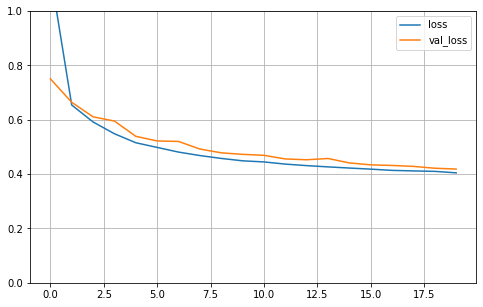

In [31]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [32]:
from scipy.stats import reciprocal
# f(x) = 1 / (x * log(b/a)) a <= x <= b

param_distribution = {
    'hidden_layers': (1,2,3,4),
    'layer_size': tuple(np.arange(1, 10)),
    'learning_rate': reciprocal(1e-4, 1e-3),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model, param_distribution, 
                                      n_iter=3, 
                                      cv = 3, # cross_validation
                                      n_jobs=1)
random_search_cv.fit(x_train_scaled, y_train, epochs = 20,
                    validation_data = (x_valid_scaled, y_valid),
                    callbacks=callbacks)

# cross_validation: 训练集分成n份，n-1训练，最后一份验证. 默认n=3

Epoch 1/20
242/242 [==============================] - 0s 1ms/step - loss: 3.5678 - val_loss: 2.9686
Epoch 2/20
242/242 [==============================] - 0s 1ms/step - loss: 2.4381 - val_loss: 2.1273
Epoch 3/20
242/242 [==============================] - 0s 1ms/step - loss: 1.7796 - val_loss: 1.5920
Epoch 4/20
242/242 [==============================] - 0s 1ms/step - loss: 1.3607 - val_loss: 1.2532
Epoch 5/20
242/242 [==============================] - 0s 1ms/step - loss: 1.1001 - val_loss: 1.0426
Epoch 6/20
242/242 [==============================] - 0s 1ms/step - loss: 0.9450 - val_loss: 0.9195
Epoch 7/20
242/242 [==============================] - 0s 1ms/step - loss: 0.8561 - val_loss: 0.8488
Epoch 8/20
242/242 [==============================] - 0s 1ms/step - loss: 0.8058 - val_loss: 0.8075
Epoch 9/20
242/242 [==============================] - 0s 1ms/step - loss: 0.7761 - val_loss: 0.7822
Epoch 10/20
242/242 [==============================] - 0s 1ms/step - loss: 0.7564 - val_loss: 0.7648

121/121 [==============================] - 0s 679us/step - loss: 0.5025
Epoch 1/20
242/242 [==============================] - 0s 1ms/step - loss: 2.9569 - val_loss: 1.5286
Epoch 2/20
242/242 [==============================] - 0s 1ms/step - loss: 1.1406 - val_loss: 0.9837
Epoch 3/20
242/242 [==============================] - 0s 1ms/step - loss: 0.8558 - val_loss: 0.8323
Epoch 4/20
242/242 [==============================] - 0s 1ms/step - loss: 0.7662 - val_loss: 0.7780
Epoch 5/20
242/242 [==============================] - 0s 1ms/step - loss: 0.7233 - val_loss: 0.7493
Epoch 6/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6964 - val_loss: 0.7284
Epoch 7/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6772 - val_loss: 0.7099
Epoch 8/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6618 - val_loss: 0.6956
Epoch 9/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6492 - val_loss: 0.6838
Epoch 10/20
242/242 [=======

242/242 [==============================] - 0s 1ms/step - loss: 0.5484 - val_loss: 0.5870
Epoch 19/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5423 - val_loss: 0.5803
Epoch 20/20
121/121 [==============================] - 0s 689us/step - loss: 0.5403
Epoch 1/20
242/242 [==============================] - 0s 1ms/step - loss: 3.1428 - val_loss: 1.5831
Epoch 2/20
242/242 [==============================] - 0s 1ms/step - loss: 1.1142 - val_loss: 0.8948
Epoch 3/20
242/242 [==============================] - 0s 1ms/step - loss: 0.7727 - val_loss: 0.7564
Epoch 4/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6779 - val_loss: 0.7039
Epoch 5/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6354 - val_loss: 0.6744
Epoch 6/20
242/242 [==============================] - 0s 1ms/step - loss: 0.6091 - val_loss: 0.6526
Epoch 7/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5894 - val_loss: 0.6348
Epoch 8/20
242/242 [======

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f96383d0438>, as the constructor either does not set or modifies parameter layer_size

In [ ]:
# from scipy.stats import reciprocal

# reciprocal.rvs(1e-4, 1e-2, size=10)

In [ ]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)